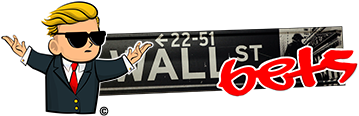

# Time series data

## Collecting data from Reddit API

### Get comments in bulk from the (superior) pushshift.io API
(one submission/post at a time)

In [ ]:
import requests
def get_pushshift_comments(link_id, limit=20000):
  """
  Returns df
  """
  # API supports up to 20000 comments at once
  assert limit <= 20000

  print(f"Link_id: {link_id}")

  comms_batches = []
  request = requests.get(f"https://api.pushshift.io/reddit/comment/search?link_id={link_id}&limit={limit}&sort=asc")

  request.raise_for_status()

  request = request.json()
  comms_batch = pd.DataFrame.from_records(request['data'], columns=["id", "score", "total_awards_received", "created_utc"])
  comms_batches.append(comms_batch)
  while len(comms_batch) == limit:
    last_utc = comms_batch.iloc[-1]["created_utc"]-1

    request = requests.get(f"https://api.pushshift.io/reddit/comment/search?link_id={link_id}&limit={limit}&sort=asc&after={last_utc}")

    request = request.json()
    comms_batch = pd.DataFrame.from_records(request['data'], columns=["id", "score", "total_awards_received", "created_utc"])
    comms_batches.append(comms_batch)
  comms = pd.concat(comms_batches)
  comms.drop_duplicates(inplace=True)
  comms["submission_id"] = link_id
  return comms

### Get information about comments belonging to all the submissions

In [ ]:
import time
comms_df = pd.read_csv("comments_raw.csv", na_filter=False)

countfile = open("submission_counter.txt", "r")
last_index = int(countfile.read())
countfile.close()
print("Starting from ", last_index)
df = pd.read_csv('with_changed_timestamp_zone.csv', na_filter=False)[last_index:]
comms_batch_dfs = [comms_df]
total = last_index + df.shape[0]
retry = True
for index, row in df.iterrows():
  retry = True
  while retry:
    try:
      comms_batch_dfs.append(get_pushshift_comments(row["id"], limit=20000))
      retry = False
    except:
      print("Request failed. Retrying...")
      time.sleep(1)

  if index % 100 == 0 :
    print(f"{index}/{total} processed")
    comms_df = pd.concat(comms_batch_dfs)
    comms_df.to_csv('comments_raw.csv', index=False)
    comms_batch_dfs = [comms_df]
    with open('submission_counter.txt', 'w') as f:
      f.write(str(index))
comms_df = pd.concat(comms_batch_dfs)
comms_df.to_csv('comments_raw.csv', index=False)

with open('submission_counter.txt', 'w') as f:
  f.write(str(total))

print("DONE")

## Datetime preprocessing

In [ ]:
df = pd.read_csv('comments_raw.csv', na_filter=False)
df.head(3)

,id,score,total_awards_received,created_utc,submission_id
0,gkz0vlt,2,0,1611767974,l69fvk
1,gkz1huj,2,0,1611768175,l69fvk
2,glazjys,12,0,1611961989,l87ci6


In [ ]:
df.describe()

,score,total_awards_received,created_utc
count,672514.000000,672514.000000,6.725140e+05
mean,8.572131,0.008021,1.611982e+09
std,133.559922,0.281789,2.837524e+05
min,-991.000000,0.000000,1.611102e+09
25%,1.000000,0.000000,1.611846e+09
50%,1.000000,0.000000,1.611902e+09
75%,4.000000,0.000000,1.612140e+09
max,24782.000000,103.000000,1.621363e+09


In [ ]:
df = pd.read_csv('with_most_dominant_colors.csv', na_filter=False)

df = df.drop(['url', 'processed_title', 'processed_body', 'processed_emoji', 'domain', 'file_path', 'processed_image_text', 'processed_image_objects', ],axis=1)

cols = [x for x in df.columns if x.startswith("color")]

df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

df = df.fillna(0)

df_dummies = pd.get_dummies(df[df.columns.difference(['timestamp_unix', 'id'])])
df_dummies['timestamp_unix'] = df['timestamp_unix']
df_dummies['id'] = df['id']

df = df_dummies

# remove 27th and 28th if the post wasn't popular
df_accepted = df[~(((df["day"] == 27) | (df["day"] == 28)) & (df["score"] < 100))]
df_rejected = df[(((df["day"] == 27) | (df["day"] == 28)) & (df["score"] < 100))]
df = df_accepted.append(df_rejected.sample(frac=0.1))

df = df.drop(["year", "day", "comms_num", "upvote_ratio"], axis=1)

df.to_csv('final_df_with_id_and_timestamp.csv', index=False)
df.head(3) 

,body_amc,body_buy,body_chars_number,body_chars_per_word,body_compani,body_day,body_emoji_number,body_fuck,body_fund,body_gme,body_hashtags_number,body_hold,body_know,body_like,body_links_number,body_make,body_market,body_money,body_numbers_number,body_peopl,body_price,body_robinhood,body_sell,body_share,body_short,body_stock,body_thi,body_think,body_time,body_trade,body_want,body_words_number,color_1_h,color_1_s,color_1_v,color_2_h,color_2_s,color_2_v,color_3_h,color_3_s,...,title_guy,title_hold,title_let,title_like,title_market,title_moon,title_nok,title_numbers_number,title_retard,title_robinhood,title_sell,title_share,title_short,title_stock,title_stop,title_thi,title_time,title_today,title_trade,title_words_number,body_sentiment_Negative,body_sentiment_Neutral,body_sentiment_Positive,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,title_sentiment_Negative,title_sentiment_Neutral,title_sentiment_Positive,type_deleted_image,type_image,type_other,type_self,type_video,timestamp_unix,id
1,0.0,0.0,0,0.000000,0.0,0.0,0,0.0,0.000000,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,97.745155,0.002452,0.963575,116.076149,0.000266,0.999419,78.905243,0.010683,...,0.0,0.779558,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,2021-01-29 23:12:20+09:00,l87ci6
2,0.0,0.0,806,5.597222,0.0,0.0,0,0.0,0.000000,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,144,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,2021-02-04 05:17:59+09:00,lc8dnh
6,0.0,0.0,613,5.623853,0.0,0.0,0,0.0,0.739008,0.0,1,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.673696,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,109,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,2021-02-03 20:17:48+09:00,lbx3p4


In [ ]:
df = pd.read_csv('comments_raw.csv', na_filter=False)
df_posts = pd.read_csv('final_df_with_id_and_timestamp.csv', na_filter=False)

posts_ids = df_posts.id.unique()

print(f"Records number before filter: {len(df)}")

df = df.loc[df['submission_id'].isin(posts_ids)]

print(f"Records number after filter: {len(df)}")

df.to_pickle('comments_with_filtered_posts.pkl')

Records number before filter: 672514
Records number after filter: 660768


In [ ]:
df = pd.read_csv('final_df_with_id_and_timestamp.csv', na_filter=False)

def map(value):
    timestamp = datetime.strptime(value, '%Y-%m-%d %H:%M:%S%z').timestamp()

    return int(timestamp)

df['timestamp_epoch'] = df.timestamp_unix.apply(map)

df.to_pickle('final_df_with_timestamp_epoch.pkl')

df[['timestamp_epoch', 'timestamp_unix', 'id']].head(5)

,timestamp_epoch,timestamp_unix,id
0,1611929540,2021-01-29 23:12:20+09:00,l87ci6
1,1612383479,2021-02-04 05:17:59+09:00,lc8dnh
2,1612351068,2021-02-03 20:17:48+09:00,lbx3p4
3,1611554070,2021-01-25 14:54:30+09:00,l4pdma
4,1612343894,2021-02-03 18:18:14+09:00,lbu4yp


In [ ]:
df = pd.read_pickle('comments_with_filtered_posts.pkl')

df_posts = pd.read_pickle('final_df_with_timestamp_epoch.pkl')
df_posts = df_posts[['id', 'timestamp_epoch']]
df_posts.rename(columns={'id': 'submission_id'}, inplace=True)
df_t = pd.merge(df, df_posts, how='left', left_on='submission_id', right_on='submission_id')

df_t.to_pickle('comments_with_post_timestamp.pkl') 
print(df_t.shape)
df_t.head(5)

,id,score,total_awards_received,created_utc,submission_id,post_timestamp
2,glazjys,12,0,1611961989,l87ci6,1611929540
3,glazjx8,37,0,1611961989,l87ci6,1611929540
4,glazlb4,6,0,1611962005,l87ci6,1611929540
5,glaznq1,98,0,1611962035,l87ci6,1611929540
6,glaznuf,33,0,1611962037,l87ci6,1611929540


In [ ]:
df = pd.read_pickle('comments_with_post_timestamp.pkl')

nine_hours = 60*60*9

# def map(row):
#     diff = (row.created_utc - nine_hours) - row.post_timestamp
#     return diff

# df['time_diff'] = df.apply(map, axis='columns')

df['time_diff'] = df['created_utc'] - nine_hours - df['timestamp_epoch']

df.to_pickle('comments_with_time_diffrence.pkl') 

df.head(5)

,id,score,total_awards_received,created_utc,submission_id,post_timestamp,time_diff
2,glazjys,12,0,1611961989,l87ci6,1611929540,49
3,glazjx8,37,0,1611961989,l87ci6,1611929540,49
4,glazlb4,6,0,1611962005,l87ci6,1611929540,65
5,glaznq1,98,0,1611962035,l87ci6,1611929540,95
6,glaznuf,33,0,1611962037,l87ci6,1611929540,97


In [ ]:
df.describe()

,score,total_awards_received,created_utc,post_timestamp,time_diff
count,660768.000000,660768.000000,6.607680e+05,6.607680e+05,6.607680e+05
mean,8.686126,0.008139,1.611984e+09,1.611935e+09,1.693303e+04
std,134.737040,0.284206,2.816231e+05,2.451358e+05,1.317667e+05
min,-991.000000,0.000000,1.611102e+09,1.611069e+09,0.000000e+00
25%,1.000000,0.000000,1.611846e+09,1.611809e+09,2.731000e+03
50%,1.000000,0.000000,1.611904e+09,1.611861e+09,6.119000e+03
75%,4.000000,0.000000,1.612141e+09,1.612094e+09,1.506500e+04
max,24782.000000,103.000000,1.621363e+09,1.612966e+09,9.397618e+06


## Timeseries

In [ ]:
df = pd.read_pickle('comments_with_time_diffrence.pkl')

df.submission_id.value_counts().nlargest(50)

l6y2hy    94517
l7iorh    89941
l9lvrn    68400
l692dj    65988
l6cb1x    56470
l9wner    28453
l6x130    19930
la0nb6    14732
l7tu52     6756
lal105     5314
l9hqn0     4689
l7z8pf     4131
l8hsjd     3537
lavgj3     3515
l8lxuy     3485
l71rdv     3415
lfm36e     3236
l92fas     3093
l77lgx     3065
l8rv8b     3063
lgy5ci     2927
l75mep     2907
l7sx9e     2891
l6mwjk     2819
l7ixaz     2733
lgvbcc     2702
laef86     2697
la8ox3     2654
l7205q     2614
laferl     2252
l78xr0     2222
lb02kr     2215
l6ocfn     2070
l8jwmx     2046
lgupsw     1858
lfkprt     1850
l9wzh3     1767
l88b8r     1752
l6n3et     1597
laqhcb     1436
l8ynh1     1423
l7ohbt     1387
l8hfhy     1351
lb70ix     1317
lgpwez     1301
l9sow3     1219
l8efqp     1153
l6tfyh     1149
lazzaa     1003
l6omgp      990
Name: submission_id, dtype: int64

In [ ]:
hour_millis = 60 * 60

hours_range = 25

df = pd.read_pickle('comments_with_time_diffrence.pkl')

def map(group):
  id = group.head(1).submission_id.values[0]
  result = {}
  result['post_id'] = id

  for hour in range(1, hours_range):
    key = f'{hour}_hour'
    min = (hour - 1) * hour_millis
    max = hour * hour_millis
    
    value = group[((group["time_diff"] >= min) & (group["time_diff"] < max))].shape[0]

    result[key] = value  

  return result
            
applied_df = df.groupby('submission_id').apply(map)

list_of_dict = applied_df.to_list()

df = pd.DataFrame(list_of_dict)

df.to_pickle('time_series.pkl') 
df.head(3)

,post_id,1_hour,2_hour,3_hour,4_hour,5_hour,6_hour,7_hour,8_hour,9_hour,10_hour,11_hour,12_hour,13_hour,14_hour,15_hour,16_hour,17_hour,18_hour,19_hour,20_hour,21_hour,22_hour,23_hour
0,l0x36m,5,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,l0yf05,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,l0yu2y,19,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
interval_minutes = 10

range_hours = 24
range_minutes = range_hours * 60

minutes_seconds = 60

df = pd.read_pickle('comments_with_time_diffrence.pkl')

def map(group):
  id = group.head(1).submission_id.values[0]
  result = {}
  result['post_id'] = id

  for current_interval in range(interval_minutes, range_minutes, interval_minutes):
    key = f'{current_interval}_minute'
    min = (current_interval - interval_minutes) * minutes_seconds
    max = current_interval * minutes_seconds
    
    value = group[((group["time_diff"] >= min) & (group["time_diff"] < max))].shape[0]

    result[key] = value  

  return result
            
applied_df = df.groupby('submission_id').apply(map)

list_of_dict = applied_df.to_list()

df = pd.DataFrame(list_of_dict)

df.to_pickle('time_series_minutes.pkl') 
df.head(3)

,post_id,10_minute,20_minute,30_minute,40_minute,50_minute,60_minute,70_minute,80_minute,90_minute,100_minute,110_minute,120_minute,130_minute,140_minute,150_minute,160_minute,170_minute,180_minute,190_minute,200_minute,210_minute,220_minute,230_minute,240_minute,250_minute,260_minute,270_minute,280_minute,290_minute,300_minute,310_minute,320_minute,330_minute,340_minute,350_minute,360_minute,370_minute,380_minute,390_minute,...,1040_minute,1050_minute,1060_minute,1070_minute,1080_minute,1090_minute,1100_minute,1110_minute,1120_minute,1130_minute,1140_minute,1150_minute,1160_minute,1170_minute,1180_minute,1190_minute,1200_minute,1210_minute,1220_minute,1230_minute,1240_minute,1250_minute,1260_minute,1270_minute,1280_minute,1290_minute,1300_minute,1310_minute,1320_minute,1330_minute,1340_minute,1350_minute,1360_minute,1370_minute,1380_minute,1390_minute,1400_minute,1410_minute,1420_minute,1430_minute
0,l0wyi2,8,2,2,2,2,2,0,1,3,1,0,1,0,0,0,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,l0x0s4,10,3,12,7,4,1,2,0,1,3,0,0,2,1,1,3,1,1,2,1,3,2,2,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,l0x25w,10,8,10,4,4,3,3,0,2,1,2,5,4,9,6,4,3,3,2,4,4,2,3,4,2,2,1,3,4,4,5,6,7,2,7,2,3,2,3,...,0,2,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [ ]:
df = pd.read_pickle('time_series.pkl')

post_id = 'l7tu52' #6756 comments

df_post = df.loc[df['post_id'] == post_id]
df_post = df_post.drop(columns='post_id')

df = df_post.T
df.columns = ['comments_number']
df = df.reset_index(drop=True)
df['comments_cumsum'] = df['comments_number'].cumsum()
df.head(3)

,comments_number,comments_cumsum
0,776,776
1,2253,3029
2,1427,4456


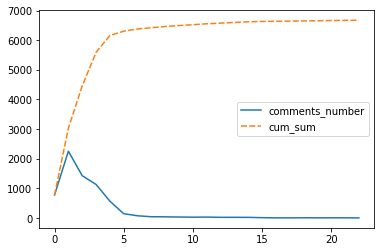

In [ ]:
sns.lineplot(data=df)

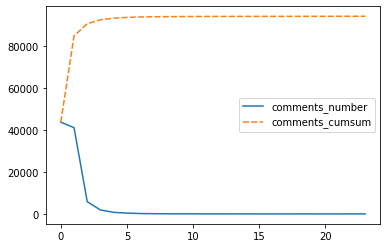

In [ ]:
df = pd.read_pickle('time_series.pkl')

post_id = 'l6y2hy' #94517 comments

df_post = df.loc[df['post_id'] == post_id]
df_post = df_post.drop(columns='post_id')

df = df_post.T
df.columns = ['comments_number']
df = df.reset_index(drop=True)
df['comments_cumsum'] = df['comments_number'].cumsum()

sns.lineplot(data=df)